<a href="https://colab.research.google.com/github/kapil0808/Kaggle-first-problem/blob/main/Churn_Prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import roc_auc_score,confusion_matrix,roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

import datetime as dt

% matplotlib inline

In [79]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Churn Prediction/train_v2.csv',dtype={'is_churn':np.int8})
members = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Churn Prediction/members_v3.csv',parse_dates=['registration_init_time'],dtype={'city':np.int8,'bd':np.int8,
                                                                                         'registered_via':np.int8})
transactions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Churn Prediction/transactions_v2.csv',parse_dates=['transaction_date','membership_expire_date'],
                          dtype={'payment_method_id':np.int8,'payment_plan_days':np.int8,'plan_list_price':np.int8,
                                'actual_amount_paid':np.int8,'is_auto_renew':np.int8,'is_cancel':np.int8})

user_log = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Churn Prediction/user_logs_v2.csv',parse_dates=['date'],dtype={'num_25':np.int16,'num_50':np.int16,
                                    'num_75':np.int16,'num_985':np.int16,'num_100':np.int16,'num_unq':np.int16})

In [80]:
print('Number of rows  & columns',train.shape)
train.head(3)

Number of rows  & columns (970960, 2)


,msno,is_churn
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1


In [81]:
print('Number of rows  & columns',members.shape)
members.head(3)

Number of rows  & columns (6769473, 6)


,msno,city,bd,gender,registered_via,registration_init_time
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,NaN,11,2011-09-11
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,2011-09-14
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,NaN,11,2011-09-15


In [82]:
print('Number of rows & columns',transactions.shape)
transactions.head(3)

Number of rows & columns (1431009, 9)


,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,32,90,42,42,0,2017-01-31,2017-05-04,0
1,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,-107,-107,1,2015-08-09,2019-04-12,0
2,+/GXNtXWQVfKrEDqYAzcSw2xSPYMKWNj22m+5XkVQZc=,36,30,-76,-76,1,2017-03-03,2017-04-22,0


In [83]:
print('Number of rows & columns',user_log.shape)
user_log.head(3)

Number of rows & columns (18396362, 9)


,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=,2017-03-31,8,4,0,1,21,18,6309.273
1,nTeWW/eOZA/UHKdD5L7DEqKKFTjaAj3ALLPoAWsU8n0=,2017-03-30,2,2,1,0,9,11,2390.699
2,2UqkWXwZbIjs03dHLU9KHJNNEvEkZVzm69f3jCS+uLI=,2017-03-31,52,3,5,3,84,110,23203.337


In [84]:
print('\nTrain:',train.describe().T)
print('\nMembers:',members.describe().T)
print('\nTransactions:',transactions.describe().T)
print('\nUser log:',user_log.describe().T)


Train:              count      mean       std  min  25%  50%  75%  max
is_churn  970960.0  0.089942  0.286099  0.0  0.0  0.0  0.0  1.0

Members:                     count      mean        std    min  25%  50%   75%    max
city            6769473.0  3.847358   5.478359    1.0  1.0  1.0   4.0   22.0
bd              6769473.0  9.763688  15.354561 -128.0  0.0  0.0  21.0  126.0
registered_via  6769473.0  5.253069   2.361398   -1.0  4.0  4.0   7.0   19.0

Transactions:                         count       mean        std  ...   50%   75%    max
payment_method_id   1431009.0  37.918355   4.964805  ...  40.0  41.0   41.0
payment_plan_days   1431009.0  18.432050  39.830162  ...  30.0  30.0  120.0
plan_list_price     1431009.0 -21.387690  94.768896  ... -76.0  99.0  126.0
actual_amount_paid  1431009.0 -20.556024  94.926916  ... -76.0  99.0  127.0
is_auto_renew       1431009.0   0.785303   0.410612  ...   1.0   1.0    1.0
is_cancel           1431009.0   0.024551   0.154753  ...   0.0   0.0    1.0

In [85]:
train = pd.merge(train,members,on='msno',how='left')
train = pd.merge(train,transactions,how='left',on='msno',left_index=True, right_index=True)
train = pd.merge(train,user_log,how='left',on='msno',left_index=True, right_index=True)

In [86]:
del members,transactions,user_log
print('Number of rows & columns',train.shape)

Number of rows & columns (970960, 23)


In [87]:
train.head(3)

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,28.0,male,3.0,2013-12-23,32,90,42,42,0,2017-01-31,2017-05-04,0,2017-03-31,8,4,0,1,21,18,6309.273
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13.0,20.0,male,3.0,2013-12-23,41,30,-107,-107,1,2015-08-09,2019-04-12,0,2017-03-30,2,2,1,0,9,11,2390.699
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13.0,18.0,male,3.0,2013-12-27,36,30,-76,-76,1,2017-03-03,2017-04-22,0,2017-03-31,52,3,5,3,84,110,23203.337


In [88]:
train[['registration_init_time' ,'transaction_date','membership_expire_date','date']].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning an

,registration_init_time,transaction_date,membership_expire_date,date
count,860967,970960,970960,970960
unique,4749,820,1818,31
top,2015-10-09 00:00:00,2017-03-31 00:00:00,2017-04-30 00:00:00,2017-03-30 00:00:00
freq,1575,130414,79283,32331
first,2004-03-26 00:00:00,2015-01-01 00:00:00,2016-04-20 00:00:00,2017-03-01 00:00:00
last,2017-04-24 00:00:00,2017-03-31 00:00:00,2036-10-15 00:00:00,2017-03-31 00:00:00


In [89]:
train[['registration_init_time' ,'transaction_date','membership_expire_date','date']].isnull().sum()

registration_init_time    109993
transaction_date               0
membership_expire_date         0
date                           0
dtype: int64

In [90]:
train['registration_init_time'] = train['registration_init_time'].fillna(value=pd.to_datetime('09/10/2015'))

In [91]:
def date_feature(df):
    
    col = ['registration_init_time' ,'transaction_date','membership_expire_date','date']
    var = ['reg','trans','mem_exp','user_']
   
    
    for i ,j in zip(col,var):
        df[j+'_day'] = df[i].dt.day.astype('uint8')
        df[j+'_weekday'] = df[i].dt.weekday.astype('uint8')        
        df[j+'_month'] = df[i].dt.month.astype('uint8') 
        df[j+'_year'] =df[i].dt.year.astype('uint16') 

date_feature(train)

In [92]:
train.head(5)

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,reg_day,reg_weekday,reg_month,reg_year,trans_day,trans_weekday,trans_month,trans_year,mem_exp_day,mem_exp_weekday,mem_exp_month,mem_exp_year,user__day,user__weekday,user__month,user__year
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,28.0,male,3.0,2013-12-23,32,90,42,42,0,2017-01-31,2017-05-04,0,2017-03-31,8,4,0,1,21,18,6309.273,23,0,12,2013,31,1,1,2017,4,3,5,2017,31,4,3,2017
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13.0,20.0,male,3.0,2013-12-23,41,30,-107,-107,1,2015-08-09,2019-04-12,0,2017-03-30,2,2,1,0,9,11,2390.699,23,0,12,2013,9,6,8,2015,12,4,4,2019,30,3,3,2017
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13.0,18.0,male,3.0,2013-12-27,36,30,-76,-76,1,2017-03-03,2017-04-22,0,2017-03-31,52,3,5,3,84,110,23203.337,27,4,12,2013,3,4,3,2017,22,5,4,2017,31,4,3,2017
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,1.0,0.0,NaN,7.0,2014-01-09,36,30,-76,-76,1,2017-03-29,2017-03-31,1,2017-03-31,176,4,2,2,19,191,7100.454,9,3,1,2014,29,2,3,2017,31,4,3,2017,31,4,3,2017
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13.0,35.0,female,7.0,2014-01-25,41,30,99,99,1,2017-03-23,2017-04-23,0,2017-03-31,2,1,0,1,112,93,28401.558,25,5,1,2014,23,3,3,2017,23,6,4,2017,31,4,3,2017


In [93]:
train.columns

Index(['msno', 'is_churn', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time', 'payment_method_id', 'payment_plan_days',
       'plan_list_price', 'actual_amount_paid', 'is_auto_renew',
       'transaction_date', 'membership_expire_date', 'is_cancel', 'date',
       'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq',
       'total_secs', 'reg_day', 'reg_weekday', 'reg_month', 'reg_year',
       'trans_day', 'trans_weekday', 'trans_month', 'trans_year',
       'mem_exp_day', 'mem_exp_weekday', 'mem_exp_month', 'mem_exp_year',
       'user__day', 'user__weekday', 'user__month', 'user__year'],
      dtype='object')

In [94]:
train.isnull().sum()

msno                           0
is_churn                       0
city                      109993
bd                        109993
gender                    582055
registered_via            109993
registration_init_time         0
payment_method_id              0
payment_plan_days              0
plan_list_price                0
actual_amount_paid             0
is_auto_renew                  0
transaction_date               0
membership_expire_date         0
is_cancel                      0
date                           0
num_25                         0
num_50                         0
num_75                         0
num_985                        0
num_100                        0
num_unq                        0
total_secs                     0
reg_day                        0
reg_weekday                    0
reg_month                      0
reg_year                       0
trans_day                      0
trans_weekday                  0
trans_month                    0
trans_year

In [95]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 970960 entries, 0 to 970959
Data columns (total 39 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   msno                    970960 non-null  object        
 1   is_churn                970960 non-null  int8          
 2   city                    860967 non-null  float64       
 3   bd                      860967 non-null  float64       
 4   gender                  388905 non-null  object        
 5   registered_via          860967 non-null  float64       
 6   registration_init_time  970960 non-null  datetime64[ns]
 7   payment_method_id       970960 non-null  int8          
 8   payment_plan_days       970960 non-null  int8          
 9   plan_list_price         970960 non-null  int8          
 10  actual_amount_paid      970960 non-null  int8          
 11  is_auto_renew           970960 non-null  int8          
 12  transaction_date        970960

In [96]:
col = [ 'city', 'bd', 'gender', 'registered_via']
def missing(df,columns):
    col = columns
    for i in col:
        df[i].fillna(df[i].mode()[0],inplace=True)

missing(train,col)

In [97]:
def unique_value(df):
    col = df.columns
    for i in col:
        print('Number of unique value in {} is {}'.format(i,df[i].nunique()))

unique_value(train)

Number of unique value in msno is 970960
Number of unique value in is_churn is 2
Number of unique value in city is 21
Number of unique value in bd is 186
Number of unique value in gender is 2
Number of unique value in registered_via is 5
Number of unique value in registration_init_time is 4749
Number of unique value in payment_method_id is 37
Number of unique value in payment_plan_days is 30
Number of unique value in plan_list_price is 44
Number of unique value in actual_amount_paid is 47
Number of unique value in is_auto_renew is 2
Number of unique value in transaction_date is 820
Number of unique value in membership_expire_date is 1818
Number of unique value in is_cancel is 2
Number of unique value in date is 31
Number of unique value in num_25 is 361
Number of unique value in num_50 is 179
Number of unique value in num_75 is 94
Number of unique value in num_985 is 218
Number of unique value in num_100 is 586
Number of unique value in num_unq is 430
Number of unique value in total_se

In [98]:
train_n=train

## Univariate EDA

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'The subscription within 30 days of expiration')

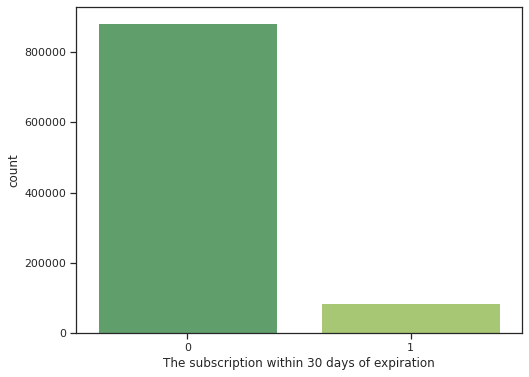

In [99]:
plt.figure(figsize=(8,6))
sns.set_style('ticks')
sns.countplot(train['is_churn'],palette='summer')
plt.xlabel('The subscription within 30 days of expiration')

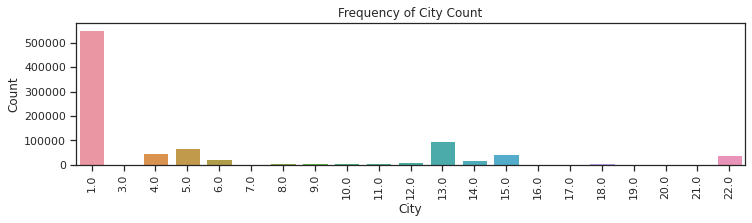

City Count [(1.0, 552591), (13.0, 97136), (5.0, 70706), (4.0, 47227), (15.0, 43187), (22.0, 41991), (6.0, 26066), (14.0, 20013), (12.0, 11383), (9.0, 9526), (11.0, 9138), (18.0, 7792), (8.0, 7589), (10.0, 6470), (17.0, 5476), (21.0, 5199), (3.0, 5057), (7.0, 2652), (16.0, 944), (20.0, 677), (19.0, 140)]


In [100]:
from collections import Counter
plt.figure(figsize=(12,12))
plt.subplot(411)
city_order = train['city'].unique()
city_order=sorted(city_order, key=lambda x: float(x))
sns.countplot(x="city", data=train , order = city_order)
plt.ylabel('Count', fontsize=12)
plt.xlabel('City', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of City Count", fontsize=12)
plt.show()
city_count = Counter(train['city']).most_common()
print("City Count " +str(city_count))

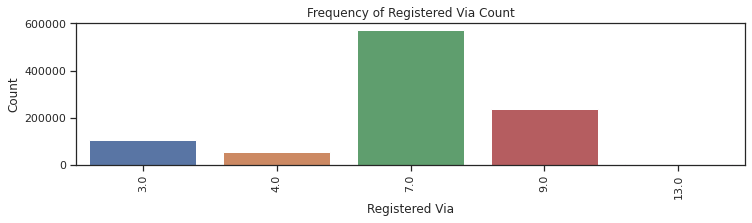

Registered Via Count [(7.0, 572677), (9.0, 235689), (3.0, 106459), (4.0, 52744), (13.0, 3391)]


In [101]:
plt.figure(figsize=(12,12))
plt.subplot(412)
R_V_order = train['registered_via'].unique()
R_V_order = sorted(R_V_order, key=lambda x: str(x))
R_V_order = sorted(R_V_order, key=lambda x: float(x))
sns.countplot(x="registered_via", data=train,order = R_V_order)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Registered Via', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Registered Via Count", fontsize=12)
plt.show()
RV_count = Counter(train['registered_via']).most_common()
print("Registered Via Count " +str(RV_count))

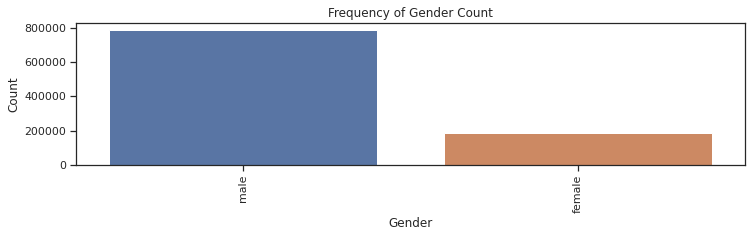

Gender Count [('male', 786616), ('female', 184344)]


In [102]:
plt.figure(figsize=(12,12))
plt.subplot(413)
sns.countplot(x="gender", data=train)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Gender Count", fontsize=12)
plt.show()
gender_count = Counter(train['gender']).most_common()
print("Gender Count " +str(gender_count))

## Multivariate EDA

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'percentage of users churning in cities')

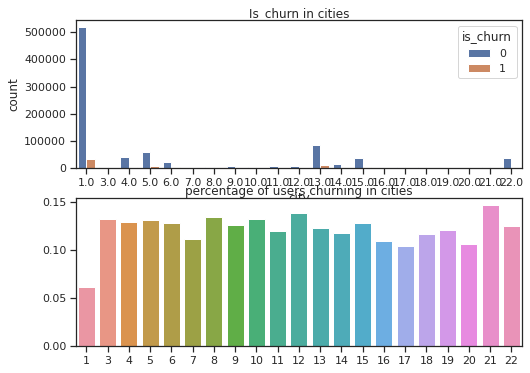

In [103]:
# 'is_churn' VS 'city'
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

sns.countplot(x='city',data=train,hue='is_churn',ax=ax1)
ax1.set_title('Is_churn in cities',pad=-15)
sns.barplot(np.delete(np.arange(1,23,1),1),np.array(train.groupby(by='city')['is_churn'].mean()),ax=ax2)
ax2.set_title('percentage of users churning in cities',pad=-15)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'percentage of users churning using register_via')

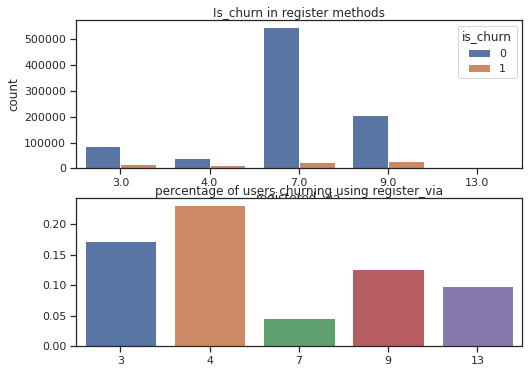

In [104]:
# 'is_churn' VS 'registered_via'
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

sns.countplot(x='registered_via',data=train,hue='is_churn',ax=ax1)
ax1.set_title('Is_churn in register methods',pad=0)

sns.barplot([3,4,7,9,13],np.array(train.groupby(by='registered_via')['is_churn'].mean()),ax=ax2)
ax2.set_title('percentage of users churning using register_via',pad=-15)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'percentage of users churning in years')

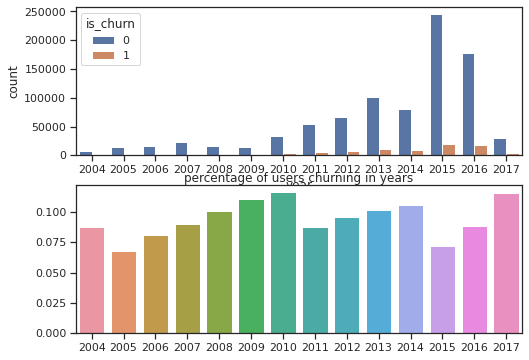

In [105]:
#  'is_churn' VS 'year'
train['registration_init_date']=pd.to_datetime(train['registration_init_time'],format='%Y%m%d')
train['year'] = pd.DatetimeIndex(train['registration_init_date']).year
train['month'] = pd.DatetimeIndex(train['registration_init_date']).month
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

sns.countplot(x='year',data=train,hue='is_churn',ax=ax1)
sns.barplot(np.arange(2004,2018,1),np.array(train.groupby(by='year')['is_churn'].mean()),ax=ax2)
ax2.set_title('percentage of users churning in years',pad=-15)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


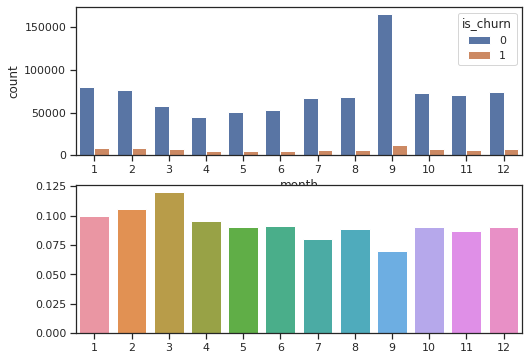

In [106]:

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

sns.countplot(x='month',data=train,hue='is_churn',ax=ax1)
sns.barplot(np.arange(1,13,1),np.array(train.groupby(by='month')['is_churn'].mean()),ax=ax2)

[ 5. 13.  1. 22.  9. 12.  6. 14.  4. 15. 18.  3. 21.  8.  7. 17. 11. 10.
 20. 16. 19.]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Payment_method_id')

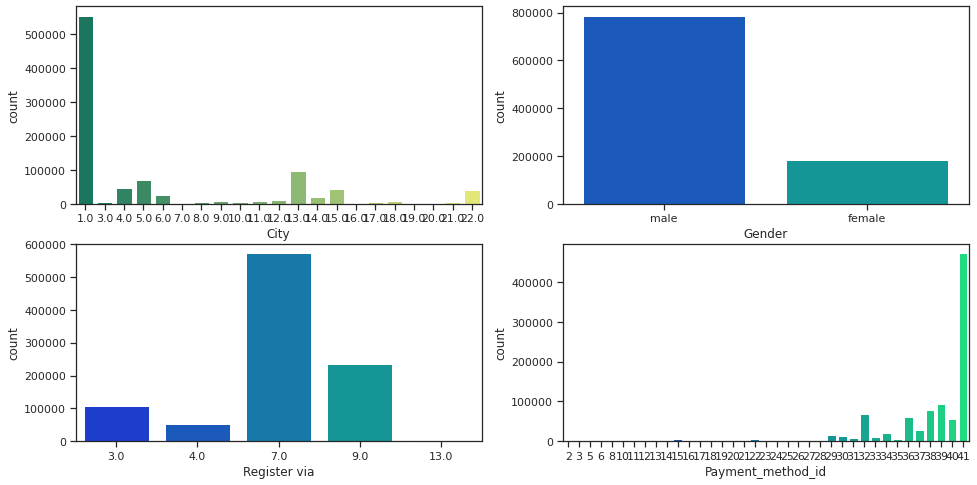

In [107]:
print(train_n['city'].unique())
fig,ax = plt.subplots(2,2,figsize=(16,8))
ax1,ax2,ax3,ax4 = ax.flatten()


sns.set(style="ticks")
sns.countplot(train_n['city'],palette='summer',ax=ax1)


ax1.set_xlabel('City')


sns.countplot(x='gender',data = train_n,palette='winter',ax=ax2)
ax2.set_xlabel('Gender')

sns.countplot(x='registered_via',data=train_n,palette='winter',ax=ax3)
ax3.set_xlabel('Register via')

sns.countplot(x='payment_method_id',data= train_n,palette='winter',ax=ax4)
ax4.set_xlabel('Payment_method_id')

In [108]:
print(train_n['bd'].describe())

count    970960.000000
mean         11.941948
std          15.811148
min        -128.000000
25%           0.000000
50%           0.000000
75%          26.000000
max         126.000000
Name: bd, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of birth day')

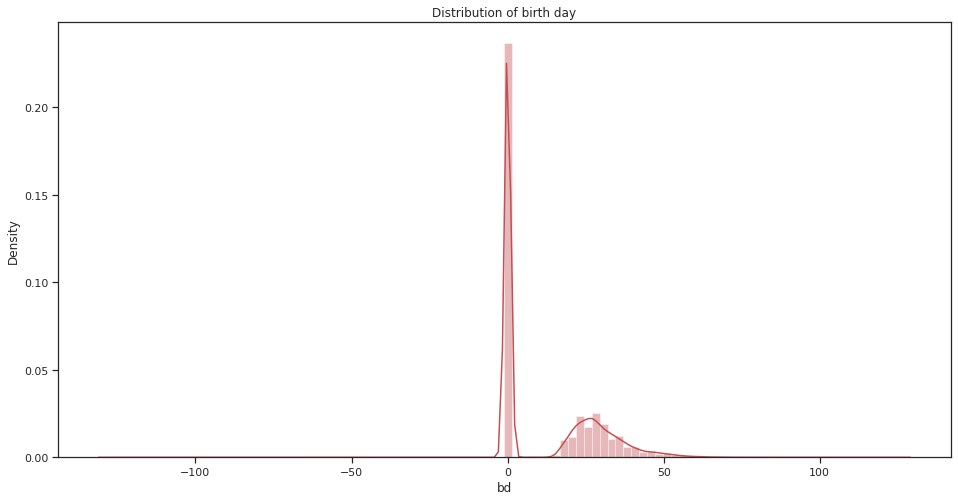

In [109]:
fig,ax = plt.subplots(1,1,figsize=(16,8))
sns.set_style('ticks')
sns.distplot(train_n['bd'].fillna(train_n['bd'].mode()[0]),bins=100,color='r',ax=ax)
ax.set_title('Distribution of birth day')

In [110]:
print(pd.crosstab(train_n['is_churn'],train_n['gender']))

gender    female    male
is_churn                
0         160404  723226
1          23940   63390


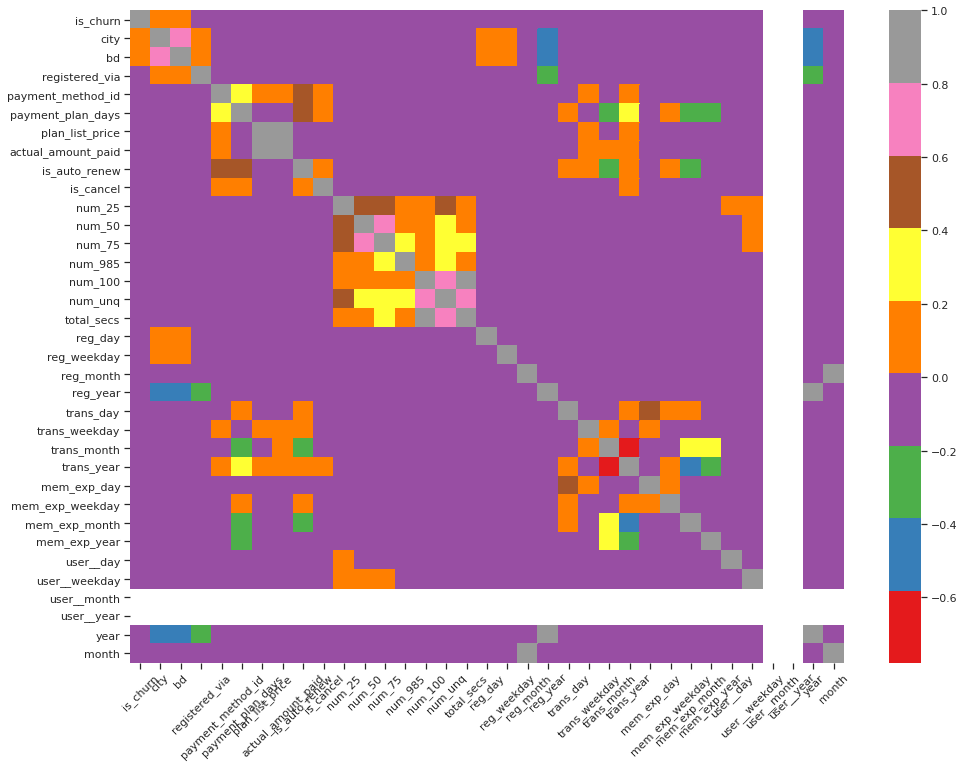

In [111]:
cor = train_n.corr()
plt.figure(figsize=(16,12))
sns.heatmap(cor,cmap='Set1',annot=False)
plt.xticks(rotation=45);

In [112]:
le = LabelEncoder()
train_n['gender'] = le.fit_transform(train_n['gender'])

In [113]:
def OHE(df):
    #col = df.select_dtypes(include=['category']).columns
    col = ['city','gender','registered_via']
    print('Categorical columns in dataset',col)
    
    c2,c3 = [],{}
    for c in col:
        if df[c].nunique()>2 :
            c2.append(c)
            c3[c] = 'ohe_'+c
    
    df = pd.get_dummies(df,columns=c2,drop_first=True,prefix=c3)
    print(df.shape)
    return df
train1 = OHE(train_n)

Categorical columns in dataset ['city', 'gender', 'registered_via']
(970960, 64)


In [114]:
train1.columns

Index(['msno', 'is_churn', 'bd', 'gender', 'registration_init_time',
       'payment_method_id', 'payment_plan_days', 'plan_list_price',
       'actual_amount_paid', 'is_auto_renew', 'transaction_date',
       'membership_expire_date', 'is_cancel', 'date', 'num_25', 'num_50',
       'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs', 'reg_day',
       'reg_weekday', 'reg_month', 'reg_year', 'trans_day', 'trans_weekday',
       'trans_month', 'trans_year', 'mem_exp_day', 'mem_exp_weekday',
       'mem_exp_month', 'mem_exp_year', 'user__day', 'user__weekday',
       'user__month', 'user__year', 'registration_init_date', 'year', 'month',
       'ohe_city_3.0', 'ohe_city_4.0', 'ohe_city_5.0', 'ohe_city_6.0',
       'ohe_city_7.0', 'ohe_city_8.0', 'ohe_city_9.0', 'ohe_city_10.0',
       'ohe_city_11.0', 'ohe_city_12.0', 'ohe_city_13.0', 'ohe_city_14.0',
       'ohe_city_15.0', 'ohe_city_16.0', 'ohe_city_17.0', 'ohe_city_18.0',
       'ohe_city_19.0', 'ohe_city_20.0', 'ohe_city_21.0', '

In [130]:
train_df_0=train1.loc[train1['is_churn'] == 0].sample(n=2000)
train_df_1=train1.loc[train1['is_churn'] == 1].sample(n=2000)
train1 = pd.concat([train_df_0, train_df_1])

In [137]:
unwanted = ['msno','is_churn','registration_init_time','transaction_date','membership_expire_date','date','registration_init_date']

X = train1.drop(unwanted,axis=1)
y = train1['is_churn'].astype('category')

,bd,gender,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,reg_day,reg_weekday,reg_month,reg_year,trans_day,trans_weekday,trans_month,trans_year,mem_exp_day,mem_exp_weekday,mem_exp_month,mem_exp_year,user__day,user__weekday,user__month,user__year,year,month,ohe_city_3.0,ohe_city_4.0,ohe_city_5.0,ohe_city_6.0,ohe_city_7.0,ohe_city_8.0,ohe_city_9.0,ohe_city_10.0,ohe_city_11.0,ohe_city_12.0,ohe_city_13.0,ohe_city_14.0,ohe_city_15.0,ohe_city_16.0,ohe_city_17.0,ohe_city_18.0,ohe_city_19.0,ohe_city_20.0,ohe_city_21.0,ohe_city_22.0,ohe_registered_via_4.0,ohe_registered_via_7.0,ohe_registered_via_9.0,ohe_registered_via_13.0
203305,0.0,1,33,30,-107,-107,1,0,0,0,1,0,29,11,7341.129,1,4,11,2013,31,4,3,2017,30,6,4,2017,24,4,3,2017,2013,11,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
84619,38.0,0,41,30,-107,-107,1,0,2,0,3,1,42,42,10456.424,17,1,3,2015,25,5,3,2017,25,1,4,2017,6,0,3,2017,2015,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
875418,29.0,0,41,30,-107,-107,1,0,0,0,0,0,12,10,2355.123,14,6,9,2014,17,5,10,2015,18,0,6,2018,28,1,3,2017,2014,9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
946163,27.0,1,36,30,-76,-76,0,0,1,0,0,0,3,4,782.791,7,5,3,2015,20,0,3,2017,19,2,4,2017,24,4,3,2017,2015,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
864094,0.0,1,39,30,-107,-107,1,0,0,0,0,0,4,1,1042.388,10,0,10,2016,28,1,2,2017,5,2,4,2017,28,1,3,2017,2016,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4590,0.0,1,41,30,99,99,1,0,3,2,2,2,160,33,42431.015,24,4,8,2012,8,2,3,2017,12,2,4,2017,23,3,3,2017,2012,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
612633,29.0,1,40,30,-107,-107,1,0,8,4,4,1,7,15,2721.054,9,5,11,2013,25,5,3,2017,2,1,5,2017,22,2,3,2017,2013,11,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26247,0.0,1,41,30,-107,-107,1,0,5,3,2,0,13,12,3508.599,10,3,9,2015,28,1,2,2017,1,5,4,2017,17,4,3,2017,2015,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
616548,0.0,1,40,30,-107,-107,1,0,24,1,2,0,41,67,9897.753,30,5,3,2013,15,2,3,2017,20,3,4,2017,27,0,3,2017,2013,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [146]:
from sklearn.decomposition import PCA
pca = PCA(n_components=12)
X_pca = pca.fit_transform(X.to_numpy())

print("Variance retained: %s" % (sum(pca.explained_variance_ratio_)))

Variance retained: 0.9999988135310414


In [147]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_pca,y, test_size=0.4, random_state=57)

In [148]:
from sklearn import preprocessing
scaler= preprocessing.StandardScaler()
scaler.fit(X_train)
X_train=pd.DataFrame(scaler.transform(X_train))
display(X_train)
X_val=pd.DataFrame(scaler.transform(X_val))

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.384588,-0.913847,-0.142540,0.117326,-0.895335,-0.717899,0.145261,-0.879851,0.602993,-0.065619,0.369799,-0.008738
1,-0.371667,-0.915046,-0.148596,0.139860,0.432474,1.004448,0.420338,0.424267,0.161311,-0.113758,0.460480,0.442681
2,-0.648548,-0.915723,-0.151807,-0.088040,-0.921705,-1.553660,0.323074,-1.439306,0.977305,-0.091851,0.549905,1.013322
3,-0.404415,-0.915763,-0.144687,-0.248117,-0.870288,0.606730,-0.308251,0.808518,0.560334,-0.192276,-1.296336,0.976537
4,0.365656,1.255827,-0.506392,-0.166365,0.820841,1.498269,-0.227068,-1.220965,0.261903,-0.173858,0.282044,0.255503
...,...,...,...,...,...,...,...,...,...,...,...,...
2395,-0.379285,-0.588411,-0.193178,-0.149997,-0.907155,-0.728143,-0.415446,0.170795,0.931330,-0.034428,0.066607,-0.330871
2396,-0.540234,1.247903,-0.528286,-0.059298,0.921815,0.327554,0.181672,-1.366288,-0.423579,-0.110670,0.026861,0.165599
2397,-0.594042,-0.591314,-0.211554,0.847391,1.257529,0.680462,1.575101,-1.156600,-0.586352,-0.079167,-0.093260,-0.997692
2398,-0.399193,-0.588412,-0.193866,-0.527072,-0.887674,-0.927262,0.441068,-0.617853,0.541152,-0.040461,0.004826,-0.578292


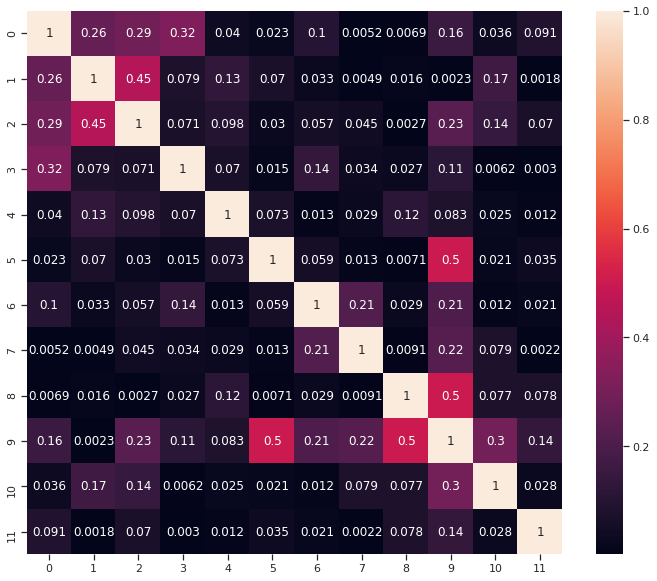

In [149]:
corrMatrix = X_train.corr(method='spearman')
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(abs(corrMatrix), annot=True)
plt.show()

In [150]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import time

start_time=time.time()
scoring = 'f1'
rfc = RandomForestClassifier()
hyperparameters = {'max_depth':[2,5,10,20],'n_estimators':[10,30,100]}
clf = GridSearchCV(rfc, param_grid=hyperparameters, scoring='f1')
clf.fit(np.array(X_train), np.squeeze(y_train))
print('Training time for Random Forest Classifier: %.2f seconds \n'%(time.time()-start_time))
print('Best parameters: ')
print(clf.best_params_)
print('Best' +scoring+":" +str(clf.best_score_))

print('Test classification report:')
y_true, y_pred = np.squeeze(y_val), clf.predict(np.array(X_val))
print(classification_report(y_true, y_pred))

print('Test AUC-ROC: '+str(roc_auc_score(y_true, y_pred)))

Training time for Random Forest Classifier: 12.94 seconds 

Best parameters: 
{'max_depth': 2, 'n_estimators': 30}
Bestf1:0.6183814811706105
Test classification report:
              precision    recall  f1-score   support

           0       0.61      0.57      0.59       807
           1       0.59      0.63      0.61       793

    accuracy                           0.60      1600
   macro avg       0.60      0.60      0.60      1600
weighted avg       0.60      0.60      0.60      1600

Test AUC-ROC: 0.6015148034771413
